Here we use ALP a secondary photon spectrum to produce an ALP event same via the Primakoff mechanism 
$$ \gamma N \to a N $$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import copy
from multiprocessing import Pool
from functools import partial
import time
from scipy import integrate

from scipy.interpolate import interp2d, griddata, interp1d


from mc import *
from lhe_output import create_LHE_file

def alp_width(ma, gag):
    """
    ALP decay width; ma = ALP mass, gag = ALP coupling to photons, defined by the interaction-gag/4 ALP F Ftilde
    """
    return ma**3 * gag**2 / (64. * np.pi)


def get_t_integral(ma, mN, A, Z, Egamma):
    s = s_term(mN,Egamma)
    if s < (mN + ma)**2:
        return np.zeros(2)
    t1, t0 = t_bounds(ma, mN, Egamma)

    # the integrand is peaked near t0
    # choose a new lower bound on the integral that is not super far from the peak to avoid
    # integration issues
    # the factor 100000 is chosen by hand, and found to give a stable estimate without numerical errrors
    t1_approx = max(t1,100000.*t0)
    sigma, error = integrate.quad(t_distribution, t1_approx, t0, args = (ma, mN, A, Z, Egamma))
    #print(sigma,"\t",error)
    
    return np.array([sigma, error])


def direct_production_cross_section(N_mcpN, photons, ma, mN, A, Z):
    """
    Nmc is number of electron-target collisions simulated
    photons is an array of photon 4 vectors from all of those collisisons
    
    returns cross-section in cm^2
    """
    gag = 1. # 1/GeV
    aEM = 1/137.
    hbarc = 0.1973269804 *1e-13 #cm * GeV
    
    r  = 0.
  
    Egamma_list = photons[:,0]

    # Use some fraction of available CPU cores
    pool = Pool(int(os.cpu_count()/2))
    # partial can be used to specify function arguments that are common for all instances
    # if there are no such arguments you dont need to wrap in partial
    sigma_list = pool.map(partial(get_t_integral, ma, mN, A, Z), Egamma_list)
    pool.close()
    sigma_list = np.array(sigma_list)

        
    r = np.sum(sigma_list[:,0])/N_mcpN
    err = np.sum(sigma_list[:,1])/N_mcpN
    
    
    # this factor was taken out of sigma_gamma N to defined t_distribution
    sigma_coef = gag**2 * aEM * Z**2 / 8.
    result = {}
    result['sigma'] = sigma_coef * r * (hbarc)**2 #* n*T_g * sigma_pN
    result['error'] = sigma_coef * err * (hbarc)**2 #* n*T_g * sigma_pN
    return result

In [2]:
ldmx_photons = np.loadtxt('../data_from_sophie.csv',delimiter=',')[:,1:] / 1000. # convert MeV to GeV
len(ldmx_photons)

57242

In [3]:
ldmx_photons_8GeV = np.loadtxt('../data_from_sophie_8_GeV.csv',delimiter=',')[:,1:] / 1000. # convert MeV to GeV
len(ldmx_photons_8GeV)

47754

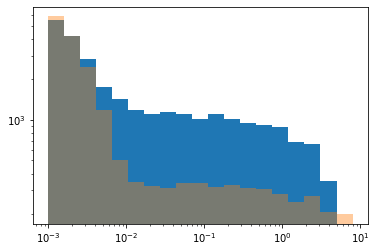

In [4]:
ebins = np.logspace(-3,np.log10(4),20)
ebins = np.logspace(-3,np.log10(8),20)
plt.hist(ldmx_photons[:,0],bins=ebins)

plt.hist(ldmx_photons_8GeV[:,0],bins=ebins,alpha=0.4)
plt.xscale('log')
plt.yscale('log')

In [19]:
len(ldmx_photons[ldmx_photons[:,0] > 1e-1])/len(ldmx_photons), len(ldmx_photons_8GeV[ldmx_photons_8GeV[:,0] > 2e-1])/len(ldmx_photons_8GeV)

(0.11970231648090562, 0.04359844201532856)

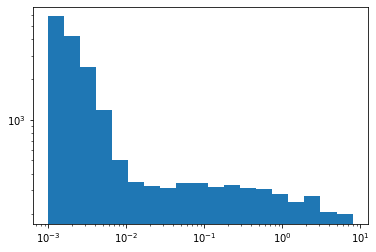

In [5]:
ebins = np.logspace(-3,np.log10(8),20)
plt.hist(ldmx_photons_8GeV[:,0],bins=ebins)
plt.xscale('log')
plt.yscale('log')

# Producing the Sample

In [14]:
ma_list = [0.01, 0.05, 0.1, 0.15, 0.2]
#ma_list = [0.1]
A = 183.84
Z = 74 #Tungsten

mN = 183.84 * 0.9314941 #For W, GeV

tau = 1.

N_mcpN = 10000 # actual number of pN collisions simulated
N_photon_subset = 20000 # number of photons to use to speed up calculation of cross-section
direct_events = []
xsec_list = []
for ma in ma_list:
    out_dir_name = "../primakoff_events_4_GeV/"+"m_" + str(int(np.floor(ma*1000.)))
    out_lhe_fname = "unweighted_events.lhe"
    os.mkdir(out_dir_name)
    result_dict = {}
    result_dict['ma'] = ma
    result_dict['tau'] = tau
    result_dict['sigma'] = direct_production_cross_section(N_mcpN*len(ldmx_photons[:N_photon_subset])/len(ldmx_photons), ldmx_photons[:N_photon_subset], ma, mN, A, Z)
    result_dict['events'] = generate_primakoff_events(ldmx_photons, ma, mN, A, Z,tau, small_t_cut_over_t0=1000, print_output = True)
    direct_events.append(result_dict)
    xsec_list.append([ma, result_dict['sigma']['sigma']])
    
    run_info_str = "<runinfo>" + "\n" \
             + "# Primakoff process: gamma N > a N\n" \
             + "# ALP Mass = " + str(ma) + "\n" \
             + "# ALP width (for gag = 1e-3/GeV) = " + str(alp_width(ma, 1e-3)) + "\n" \
             + "# Nucleus Mass = " + str(mN) + "\n" \
             + "# Nucleus A = " + str(A) + "\n" \
             + "# Nucleus Z = " + str(Z) + "\n" \
             + "# Number of Events: " + str(len(result_dict['events'])) + "\n" \
             + "# Integrated weight (for gag = 1e-3/GeV) (pb) : "+str(result_dict['sigma']['sigma']*1e36*1e-6) + "\n" + "</runinfo>" + "\n"
    create_LHE_file(ma, mN, result_dict['events'], out_dir_name+"/"+out_lhe_fname, header_str = run_info_str)
xsec_list = np.array(xsec_list)

This took me 0.39285615682601926 minutes to process 57242 events


In [17]:
ma_list = [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5]
#ma_list = [0.1]
A = 183.84
Z = 74 #Tungsten

mN = 183.84 * 0.9314941 #For W, GeV

tau = 1.

N_mcpN = 10000 # actual number of pN collisions simulated
N_photon_subset = len(ldmx_photons_8GeV) #20000 # number of photons to use to speed up calculation of cross-section
direct_events = []
xsec_list_8_GeV = []
for ma in ma_list:
    out_dir_name = "../primakoff_events_8_GeV/"+"m_" + str(int(np.floor(ma*1000.)))
    out_lhe_fname = "unweighted_events.lhe"
    os.mkdir(out_dir_name)
    result_dict = {}
    result_dict['ma'] = ma
    result_dict['tau'] = tau
    result_dict['sigma'] = direct_production_cross_section(N_mcpN*len(ldmx_photons_8GeV[:N_photon_subset])/len(ldmx_photons_8GeV), ldmx_photons_8GeV[:N_photon_subset], ma, mN, A, Z)
    result_dict['events'] = generate_primakoff_events(ldmx_photons_8GeV, ma, mN, A, Z,tau, small_t_cut_over_t0=1000, print_output = True)
    direct_events.append(result_dict)
    xsec_list_8_GeV.append([ma, result_dict['sigma']['sigma']])
    run_info_str = "<runinfo>" + "\n" \
             + "# Primakoff process: gamma N > a N\n" \
             + "# ALP Mass = " + str(ma) + "\n" \
             + "# ALP width (for gag = 1e-3/GeV) = " + str(alp_width(ma, 1e-3)) + "\n" \
             + "# Nucleus Mass = " + str(mN) + "\n" \
             + "# Nucleus A = " + str(A) + "\n" \
             + "# Nucleus Z = " + str(Z) + "\n" \
             + "# Number of Events: " + str(len(result_dict['events'])) + "\n" \
             + "# Integrated weight (for gag = 1e-3/GeV) (pb) : "+str(result_dict['sigma']['sigma']*1e36*1e-6) + "\n" + "</runinfo>" + "\n"
    create_LHE_file(ma, mN, result_dict['events'], out_dir_name+"/"+out_lhe_fname, header_str = run_info_str)
xsec_list_8_GeV = np.array(xsec_list_8_GeV)

This took me 0.12853896220525104 minutes to process 47754 events


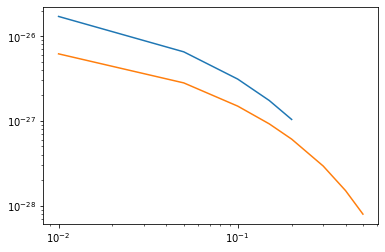

In [18]:
plt.plot(xsec_list[:,0],xsec_list[:,1])
plt.plot(xsec_list_8_GeV[:,0],xsec_list_8_GeV[:,1])
plt.xscale('log')
plt.yscale('log')

In [10]:
xsec_list

[{'sigma': 6.161302107236744e-27, 'error': 6.812231012958225e-36},
 {'sigma': 2.7787481241890276e-27, 'error': 2.4291711313227334e-36},
 {'sigma': 1.4762844474192996e-27, 'error': 1.7477543398314954e-36},
 {'sigma': 9.114600182337397e-28, 'error': 1.3499062875402418e-36},
 {'sigma': 6.022978717037333e-28, 'error': 1.1407185712550706e-36},
 {'sigma': 2.899795299893063e-28, 'error': 8.222252087728932e-37},
 {'sigma': 1.4857523836701053e-28, 'error': 7.048589453599702e-37},
 {'sigma': 7.851614955808807e-29, 'error': 5.90444981972894e-37}]

In [17]:
N_photon_subset

47754